# 4.3.	Violações dos padrões de qualidade do ar no Brasil 

Tabela 10 – Ranqueamento das cinco estações com o maior número de violações dos Padrões de Qualidade do Ar de O 3, MP10, MP2,5 e SO2 no ano de 2023. 
    TENTAR FAZER UMA TABELA ITERATIVA ONDE O USUÁRIO POSSA FILTRAR AS ESTAÇÕES

    TENTAR FAZER UM DROPDOWN MENU PARA ESCOLHER QUAL SÉRIE TEMPORAL VISUALIZAR NO LIVRO. Colocar padrões da CONAMA. 

In [9]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from itables import show
import itables.options as opt
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Setup itables
opt.lengthMenu = [10, 25, 50, 100]
opt.scrollX = True
opt.columnDefs = [{"className": "dt-center", "targets": "_all"}]

# Sample Data
df = pd.read_csv('https://lcqar.ufsc.br/files/RS0009_MP10.csv')

# Widgets
start_date = widgets.DatePicker(description='Start:', value=pd.to_datetime("2025-01-01").date())
end_date = widgets.DatePicker(description='End:', value=pd.to_datetime("2025-04-01").date())

filter_button = widgets.Button(description="Filter", button_style='primary')
csv_button = widgets.Button(description="Download CSV", button_style='success', disabled=True)

output_table = widgets.Output()
output_download = widgets.Output()
output_plot = widgets.Output()



def tratar_dados(df):
    df['datetime'] = pd.to_datetime({
      'year': df['ANO'],
      'month': df['MES'],
      'day': df['DIA'],
      'hour': pd.to_datetime(df['HORA'], format='%H:%M:%S').dt.hour
    })
    # Substitui , por . 
    df['VALOR'] = df['VALOR'].replace(',', '.', regex=True).copy()
    # Converte para float, forçando erro para NaN
    df['VALOR'] = pd.to_numeric(df['VALOR'], errors='coerce').copy()
    # Transforma valores negativos em NaN
    df.loc[df['VALOR'] < 0, 'VALOR'] = np.nan
    time_range = pd.date_range(df['datetime'].min(), df['datetime'].max(), freq='h').to_series(name='datetime')
    df = pd.merge(time_range, df,how='left')
    #df = df.set_index('datetime', drop=False)
    df['datetime'] = pd.to_datetime(df['datetime']).copy()
    return df
    
df = tratar_dados(df)
filtered_df = df.copy()

def split_nan_segments(x, y):
    """Splits x and y into segments where y is not NaN"""
    segments = []
    x = np.array(x)
    y = np.array(y)
    
    isnan = np.isnan(y)
    start = 0
    for i in range(1, len(y)):
        if isnan[i] and not isnan[i-1]:
            segments.append((x[start:i], y[start:i]))
            start = i + 1
        elif not isnan[i] and isnan[i-1]:
            start = i
    if not isnan[-1]:
        segments.append((x[start:], y[start:]))
    return segments
def iterative_raw_timeseries(df):
    df = tratar_dados(df)
    dates = df['datetime']
    # Create the figure
    #fig = go.Figure()
    fig = make_subplots(rows=1, cols=1) 
    # raw
    segments = split_nan_segments(df['datetime'], df.VALOR)
    for seg_x, seg_y in segments:
        fig.add_trace(go.Scatter(
            x=seg_x,
            y=seg_y,
            #fill='tozeroy',
            line=dict(color='rgba(153, 153, 255, 1)', width=1),
            #fillcolor='rgba(255,255,255,1)',
            #fillcolor='rgba(153, 153, 255,0.1)',
            showlegend=False,
            name='Série temporal',
            mode='lines',
            connectgaps=False
        ))
    # Update layout for better presentation
    fig.update_layout(
        title='Série temporal',
        hovermode='x unified', # Shows hover info for all traces at a given x-coordinate
        height=600, width=800,
        plot_bgcolor='rgba(0.9,0.9,0.9,0.2)')
    unidade = '(ug/m³)'
    fig.update_yaxes(title_text="Concentração<br>Série completa"+unidade, row=5, col=1)
    fig.update_xaxes(title_text="Dia/Mês/Ano Hora")
    return fig

# Filter function
def on_filter_clicked(_):
    global filtered_df
    with output_table:
        clear_output()
        mask = (df['datetime'].dt.date >= start_date.value) & (df['datetime'].dt.date <= end_date.value)
        filtered_df = df.loc[mask]
        show(filtered_df)
    
    with output_plot:
        clear_output()
        if not filtered_df.empty:
            #fig, ax = plt.subplots(figsize=(8, 3))
            fig = iterative_raw_timeseries(df)
            #ax.plot(filtered_df['datetime'], filtered_df['VALOR'], marker='o')
            #ax.set_title("Filtered Series")
            #ax.set_xlabel("Date")
            #ax.set_ylabel("Value")
            #ax.grid(True)
            #plt.xticks(rotation=45)
            #plt.tight_layout()
            display(fig)
    
    csv_button.disabled = filtered_df.empty

# CSV download function
def on_csv_clicked(_):
    with output_download:
        clear_output()
        csv_buffer = BytesIO()
        filtered_df.to_csv(csv_buffer, index=False)
        b64 = base64.b64encode(csv_buffer.getvalue()).decode()
        filename = "filtered_data.csv"
        payload = f"data:text/csv;base64,{b64}"
        html = f"""
        <html>
        <body>
        <a id="download_link" download="{filename}" href="{payload}"></a>
        <script>document.getElementById('download_link').click();</script>
        </body>
        </html>
        """
        display(HTML(html))

# Bind buttons
filter_button.on_click(on_filter_clicked)
csv_button.on_click(on_csv_clicked)

# Layout
ui = widgets.HBox([start_date, end_date, filter_button])
display(ui, output_table, output_plot, csv_button, output_download)


Output()

Output()

Button(button_style='success', description='Download CSV', disabled=True, style=ButtonStyle())

Output()

In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from itables import show
import itables.options as opt
import base64
from io import BytesIO
import matplotlib.pyplot as plt
import os
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Configure itables
opt.lengthMenu = [10, 25, 50, 100]
opt.scrollX = True

# Settings
DATA_FOLDER = 'https://lcqar.ufsc.br/files/2023'  # adjust as needed

# Caminho para a pasta de dados
rootPath = os.path.dirname(os.getcwd())

# Lendo o csv
aqmData = pd.read_csv(rootPath+'/data/Monitoramento_QAr_BR_teste.csv',encoding = 'unicode_escape')

# Create dict: station -> list of pollutants
station_pollutants = aqmData.groupby("ID_MMA")["POLUENTE"].unique().apply(list).to_dict()
# Set station list
AVAILABLE_STATIONS = sorted(station_pollutants.keys())

# Widgets
station_dropdown = widgets.Dropdown(options=AVAILABLE_STATIONS, description='Station:')
pollutant_dropdown = widgets.Dropdown(description='Pollutant:')
load_button = widgets.Button(description="Load CSV", button_style='primary')
start_date = widgets.DatePicker(description='Start date:')
end_date = widgets.DatePicker(description='End date:')
filter_button = widgets.Button(description="Apply Filter", button_style='info', disabled=True)
csv_button = widgets.Button(description="Download Filtered CSV", button_style='success', disabled=True)

# Output widgets
output_error = widgets.Output()
output_table = widgets.Output()
output_plot = widgets.Output()
output_download = widgets.Output()

# DataFrames
loaded_df = pd.DataFrame()
filtered_df = pd.DataFrame()

def tratar_dados(df):
    # Convert all to string first
    hour_str = df['HORA'].astype(str)

    # Now parse hours and minutes from string
    def parse_hour_minute(val):
        if ':' in val:
            parts = val.split(':')
            return int(parts[0]), int(parts[1])
        else:
            # If float stored as string, convert to float and extract hour/min
            f = float(val)
            hour = int(f)
            minute = int(round((f - hour) * 60))
            return hour, minute

    parsed = hour_str.apply(parse_hour_minute)
    df['HORA'] = parsed.apply(lambda x: x[0])


    df['datetime'] = pd.to_datetime({
      'year': df['ANO'],
      'month': df['MES'],
      'day': df['DIA'],
      'hour': df['HORA'],        
    }, errors='coerce')
    # Substitui , por . 
    df['VALOR'] = df['VALOR'].replace(',', '.', regex=True).copy()
    # Converte para float, forçando erro para NaN
    df['VALOR'] = pd.to_numeric(df['VALOR'], errors='coerce').copy()
    # Transforma valores negativos em NaN
    df.loc[df['VALOR'] < 0, 'VALOR'] = np.nan
    print(df)
    time_range = pd.date_range(df['datetime'].min(), df['datetime'].max(), freq='h').to_series(name='datetime')
    df = pd.merge(time_range, df,how='left')
    #df = df.set_index('datetime', drop=False)
    df['datetime'] = pd.to_datetime(df['datetime']).copy()
    return df
    
def split_nan_segments(x, y):
    """Splits x and y into segments where y is not NaN"""
    segments = []
    x = np.array(x)
    y = np.array(y)
    
    isnan = np.isnan(y)
    start = 0
    for i in range(1, len(y)):
        if isnan[i] and not isnan[i-1]:
            segments.append((x[start:i], y[start:i]))
            start = i + 1
        elif not isnan[i] and isnan[i-1]:
            start = i
    if not isnan[-1]:
        segments.append((x[start:], y[start:]))
    return segments
def iterative_raw_timeseries(df):
    df = tratar_dados(df)
    dates = df['datetime']
    # Create the figure
    #fig = go.Figure()
    fig = make_subplots(rows=1, cols=1) 
    # raw
    segments = split_nan_segments(df['datetime'], df.VALOR)
    for seg_x, seg_y in segments:
        fig.add_trace(go.Scatter(
            x=seg_x,
            y=seg_y,
            #fill='tozeroy',
            line=dict(color='rgba(153, 153, 255, 1)', width=1),
            #fillcolor='rgba(255,255,255,1)',
            #fillcolor='rgba(153, 153, 255,0.1)',
            showlegend=False,
            name='Série temporal',
            mode='lines',
            connectgaps=False
        ))
    # Update layout for better presentation
    fig.update_layout(
        title='Série temporal',
        hovermode='x unified', # Shows hover info for all traces at a given x-coordinate
        height=600, width=800,
        plot_bgcolor='rgba(0.9,0.9,0.9,0.2)')
    unidade = '(ug/m³)'
    fig.update_yaxes(title_text="Concentração<br>Série completa"+unidade, row=5, col=1)
    fig.update_xaxes(title_text="Dia/Mês/Ano Hora")
    return fig

def update_pollutants(change):
    # Get current station from widget (robust to both observer and manual call)
    selected_station = change['new'] if isinstance(change, dict) else station_dropdown.value
    
    # Get corresponding pollutants
    new_pollutants = station_pollutants.get(selected_station, [])
    
    # Save old value to restore if possible
    old_value = pollutant_dropdown.value

    # Update options with a *copy* to force change detection
    pollutant_dropdown.options = list(new_pollutants)
    
    # Set default or preserve old value if valid
    if old_value in new_pollutants:
        pollutant_dropdown.value = old_value
    elif new_pollutants:
        pollutant_dropdown.value = new_pollutants[0]
    else:
        pollutant_dropdown.value = None
# Function to update UI outputs (table, plot)
def update_outputs():
    with output_table:
        clear_output()
        show(filtered_df)
    with output_plot:
        clear_output()
        if not filtered_df.empty and 'datetime' in filtered_df.columns:
            fig = iterative_raw_timeseries(filtered_df)
            display(fig)
    csv_button.disabled = filtered_df.empty

# Load button action
def on_load_clicked(_):
    global loaded_df, filtered_df
    with output_error, output_table, output_plot, output_download:
        clear_output()
        station = station_dropdown.value
        pollutant = pollutant_dropdown.value
        filename = f"{station}.csv"
        filepath = os.path.join(DATA_FOLDER+'/'+pollutant+'/', filename)
        
        loaded_df = pd.read_csv(filepath)
        loaded_df = tratar_dados(loaded_df)
        
        filtered_df[:] = loaded_df.copy()

        if not loaded_df.empty and 'datetime' in loaded_df.columns:
            start_date.value = loaded_df['datetime'].min().date()
            end_date.value = loaded_df['datetime'].max().date()

        filter_button.disabled = False
        update_outputs()

# Date filter action
def on_filter_clicked(_):
    global filtered_df
    if 'datetime' not in loaded_df.columns:
        return
    mask = (df['datetime'].dt.date >= start_date.value) & (df['datetime'].dt.date <= end_date.value)
    filtered_df = df.loc[mask]
    update_outputs()

# CSV download button
def on_csv_clicked(_):
    with output_download:
        clear_output()
        csv_buffer = BytesIO()
        filtered_df.to_csv(csv_buffer, index=False)
        b64 = base64.b64encode(csv_buffer.getvalue()).decode()
        filename = f"{station_dropdown.value}_{pollutant_dropdown.value}_filtered.csv"
        payload = f"data:text/csv;base64,{b64}"
        html = f"""
        <a id="download_link" download="{filename}" href="{payload}"></a>
        <script>document.getElementById('download_link').click();</script>
        """
        display(HTML(html))

# Event bindings
load_button.on_click(on_load_clicked)
filter_button.on_click(on_filter_clicked)
csv_button.on_click(on_csv_clicked)


# Layout
ui_select = widgets.HBox([station_dropdown, pollutant_dropdown, load_button])
ui_dates = widgets.HBox([start_date, end_date, filter_button])
ui_download = widgets.HBox([csv_button])

station_dropdown.observe(update_pollutants, names='value')
update_pollutants({'new': station_dropdown.value})  # Trigger initial update


display(ui_select, ui_dates, output_error, output_table, output_plot, ui_download, output_download)

Output()

Output()

Output()

Output()

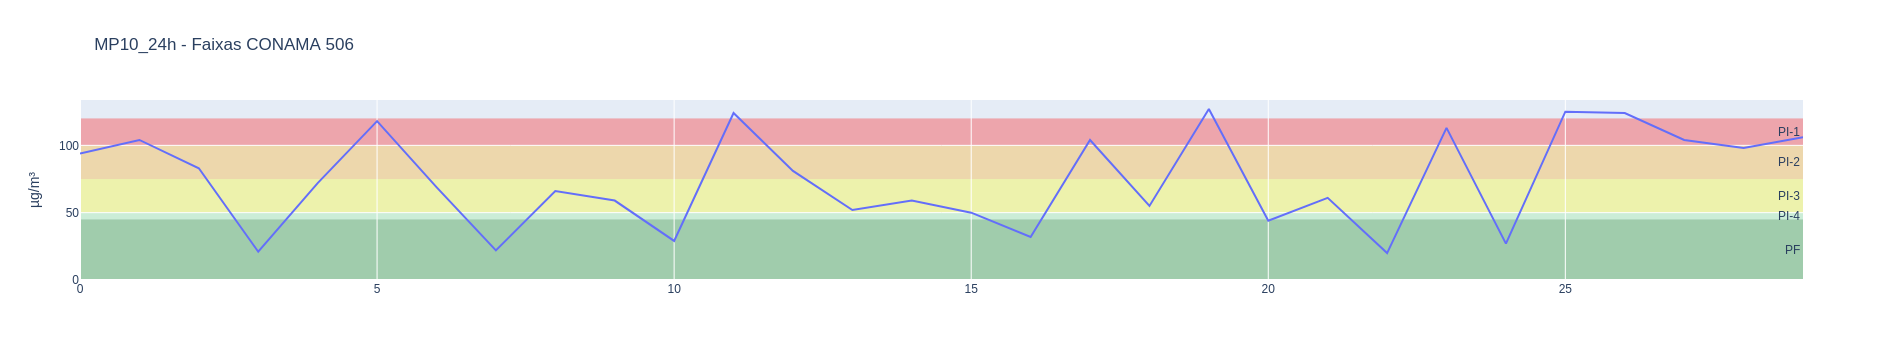

In [2]:
import pandas as pd
import plotly.graph_objects as go

# lê o CSV
df_fases = pd.read_csv("https://lcqar.ufsc.br/files/2023/fases_CONAMA506.csv")

# filtra para o poluente desejado
poluente = "MP10_24h"
df_pol = df_fases[df_fases["pollutant"] == poluente]

# cria figura
fig = go.Figure()

# adiciona faixas de cada fase
for _, row in df_pol.iterrows():
    fig.add_hrect(
        y0=row["y0"], y1=row["y1"],
        line_width=0,
        fillcolor=row["color"],
        layer="below",
        annotation_text=row["phase"],
        annotation_position="right"
    )

# exemplo: série fictícia de dados observados
import numpy as np
fig.add_scatter(
    y=np.random.randint(20, 130, size=30),
    mode='lines',
    name=f"{poluente} observado"
)

fig.update_layout(
    title=f"{poluente} - Faixas CONAMA 506",
    yaxis_title="µg/m³"
)

fig.show()